In [7]:
from pathlib import Path
import random
import sys
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color

sys.path.append("/home/psa_images/SemiF-AnnotationPipeline")
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline/segment")

from segment.semif_utils.image_stats import calculate_glcm, calculate_haralick_features_mean, calculate_edge_density_mean, calculate_eccentricity_and_solidity_mean, calculate_elongation_and_roundness_mean, calculate_area_and_aspect_ratio_mean, calculate_color_histogram, calculate_lbp_mean, calculate_color_histogram_mean, calculate_lbp, calculate_area_and_aspect_ratio, calculate_elongation_and_roundness, calculate_eccentricity_and_solidity, calculate_edge_density, calculate_object_count, calculate_haralick_features, calculate_entropy


In [9]:
batch = "MD_2022-08-26"
cutout_dir = f"/mnt/research-projects/s/screberg/longterm_images/semifield-cutouts/{batch}"
batch_dir = f"/mnt/research-projects/s/screberg/longterm_images/semifield-developed-images/{batch}"
imgs = [x for x in Path(cutout_dir).glob("*.png")]
imgs = [x for x in imgs if "_mask" not in x.stem]

In [3]:
def randpath():
    # Example usage for entropy
    randint = random.randint(0, 1000)
    image_path = str(imgs[randint])
    return image_path

In [4]:
def average_rgb(image_path, ignore_zeros=False):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR image to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if ignore_zeros:
        # Convert the image to floating-point to handle division with zero
        image_float = image_rgb.astype(float)
        # Mask out the zero-valued (black) pixels
        non_zero_mask = (image_float != 0).all(axis=-1)

        # Calculate the average color using numpy, ignoring zeros
        average_color = np.mean(image_float[non_zero_mask], axis=0)
    else:
        # Calculate the average color using numpy
        average_color = np.mean(image_rgb, axis=(0, 1))

    return average_color.astype(int)


# Calculate the average color
image_path = randpath()
avg_nonzero_color = average_rgb(image_path, ignore_zeros=True)
print("Average Nonzero Color (RGB):", avg_nonzero_color)

Average Nonzero Color (RGB): [147 155  96]


# Dominant (mode) RGB value

Dominant RGB:  (155, 173, 93)


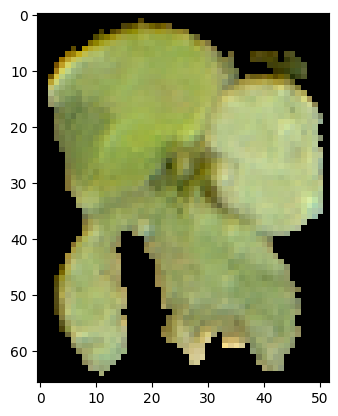

In [5]:
def make_yellow_img():
    img = np.zeros((100, 100, 3))
    img[25:75, 25:75, :] = [122, 150, 0]  # 50 x 50 = 2500
    img[75:95, 60:75, :] = [122, 150, 0]  # 20 x 15 = 300
    img[85:95, 50:60, :] = [122, 150, 0]  # 10 x 10 = 100
    img[75:85, 50:55, :] = [122, 150, 0]  # 10 x 5 = 50
    return img


def get_dominant_color_mode(image_path, ignore_zeros=False):
    from scipy.stats import mode
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if ignore_zeros:
        # Remove rows where all RGB values are zero
        image_rgb = image_rgb[np.any(image_rgb != [0, 0, 0], axis=-1)]
    else:
        image_rgb = image_rgb.reshape(-1, 3)

    # Get the mode of the non-zero rows (dominant color)
    dominant_color, count = mode(image_rgb, axis=0, keepdims=True)

    # Convert the dominant color to a tuple (R, G, B)
    dominant_color_rgb = tuple(dominant_color[0])

    return dominant_color_rgb


image_path = randpath()
dom_rgb = get_dominant_color_mode(image_path, ignore_zeros=True)
print("Dominant RGB: ", dom_rgb)

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Texture

Texture info:  {'contrast': 1314.0855614972802, 'energy': 0.28671867885824615}


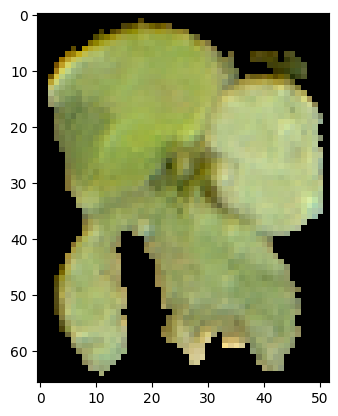

In [6]:
def calculate_texture_features(image_path):

    from skimage.feature import graycomatrix, graycoprops

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the GLCM (Gray-Level Co-Occurrence Matrix)
    distances = [1]
    angles = [0, np.pi / 4, np.pi / 2,
              3 * np.pi / 4]  # Horizontal, Diagonal, Vertical, Anti-Diagonal

    glcm = graycomatrix(gray_image,
                        distances=distances,
                        angles=angles,
                        symmetric=True,
                        normed=True)

    # Calculate texture features from the GLCM
    texture_features = {}
    texture_features['contrast'] = graycoprops(glcm, 'contrast').ravel()[0]
    texture_features['energy'] = graycoprops(glcm, 'energy').ravel()[0]

    return texture_features


# image_path = randpath()
text = calculate_texture_features(image_path)
print("Texture info: ", text)

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

[0 1]
1823857
0.4532703596768428


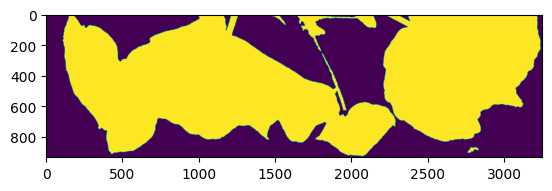

In [39]:
def read_metadata(path):
    with open(path, 'r') as f:
        data = json.loads(f.read())
    return data


def get_fov_area(batch_dir, image_id):
    # in sq-meters
    json_path = Path(batch_dir, "metadata", image_id + ".json")
    data = read_metadata(json_path)
    fov = data["camera_info"]["fov"]
    width = fov["top_right"][0] - fov["top_left"][0]
    height = fov["top_left"][1] - fov["bottom_left"][1]
    area_m = width * height
    return area_m


def leaf_area(parent_pixel_width, parent_pixel_height, parent_fov_area, mask):

    # sub_image_width = img.shape[1]  # in pixels
    # sub_image_height = img.shape[0]  # in pixels

    # calculate ground area covered by a single pixel in the parent image
    parent_area_per_pixel = parent_fov_area / (
        parent_pixel_width * parent_pixel_height)  # in square meters

    # calculate ground area covered by a single pixel in the sub-image
    sub_image_area_per_pixel = parent_area_per_pixel  # since both images have the same scale

    # read the mask (assumed to be a binary image where leaf pixels are 1 and all others are 0)
    # image_mask_path = image_path.replace(".png", "_mask.png")
    # mask = cv2.imread(image_mask_path, cv2.IMREAD_GRAYSCALE)

    # count the number of pixels that correspond to the leaf

    leaf_pixel_count = np.sum(
        mask !=
        0)  # assumes that the leaf is represented by 255 (white) in the mask
    print(leaf_pixel_count)

    # calculate the leaf area
    leaf_area = leaf_pixel_count * sub_image_area_per_pixel
    return sub_image_area_per_pixel, mask, leaf_area


# image_path = randpath().replace(".png", ".jpg")
image_id = "_".join(Path(image_path).stem.split("_")[:2])
parent_fov_area = get_fov_area(batch_dir, image_id)
img = cv2.imread(image_path)
parent_pixel_width = img.shape[1]
parent_pixel_height = img.shape[0]
mask = cv2.imread(image_path.replace(".jpg", "_mask.png"))
mask = np.where(mask != 0, 1, 0)[:, :, 0]
print(np.unique(mask))
la = leaf_area(parent_pixel_width, parent_pixel_height, parent_fov_area, mask)
print(la[2])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(mask)
plt.show()


mean grvi:  0.040465374


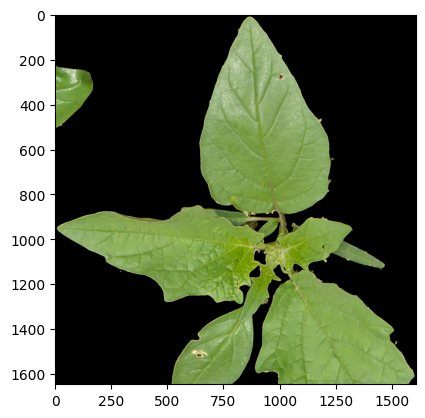

In [92]:
def calculate_grvi(image_path):
    # Load the RGB image
    img = cv2.imread(image_path).astype(np.float32)
    # img_float = img.copy()
    # img[img_float==[0,0,0]] = np.nan

    b, g, r = cv2.split(img)

    # Calculate the GRVI index
    gminr = g - r
    gplusr = g + r
    grvi = np.true_divide(gminr,
                          gplusr,
                          out=np.zeros_like(gminr),
                          where=gplusr != 0)
    grvi = np.true_divide(gminr, gplusr)

    # grvi = np.divide(gminr, gplusr) #gminr / gplusr

    # Calculate the average GRVI value for the entire image
    average_grvi = np.mean(grvi)

    return average_grvi


# Replace 'your_image_path.jpg' with the path to your image
imgs = [
    x for x in Path(
        "/mnt/research-projects/s/screberg/longterm_images/semifield-cutouts/MD_2022-08-26/"
    ).glob("*.png")
]
imgs = [x for x in imgs if "_mask" not in x.stem]
randint = random.randint(0, 1000)
# image_path = str(imgs[randint])
# image_path = str(imgs[randint]).replace(".jpg", ".png")

# Calculate the Leaf Area Index (LAI)
grvi = calculate_grvi(image_path)
print("mean grvi: ", grvi)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

In [247]:
import math


class Camera:

    def __init__(self, focal_length, sensor_width, sensor_height, altitude,
                 roll, pitch, yaw):
        self.focal_length = focal_length
        self.sensor_width = sensor_width
        self.sensor_height = sensor_height
        self.altitude = altitude
        self.roll = math.radians(roll)
        self.pitch = math.radians(pitch)
        self.yaw = math.radians(yaw)

    def calculate_field_of_view(self):
        self.h_fov = 2 * math.atan(self.sensor_width /
                                   (2 * self.focal_length))  # in radians
        self.v_fov = 2 * math.atan(self.sensor_height /
                                   (2 * self.focal_length))  # in radians

    def calculate_real_world_dimensions(self):
        self.real_width = 2 * self.altitude * math.tan(
            self.h_fov / 2)  # in meters
        self.real_height = 2 * self.altitude * math.tan(
            self.v_fov / 2)  # in meters

    def calculate_real_world_area(self):
        # approximate the effect of roll, pitch, and yaw on the area covered
        self.real_area = self.real_width * self.real_height * math.cos(
            self.roll) * math.cos(self.pitch)


focal_length_m = 55 / 1000
sensor_width = 35.7 / 1000
sensor_height = 23.8 / 1000
camera = Camera(focal_length=focal_length_m,
                sensor_width=sensor_width,
                sensor_height=sensor_height,
                altitude=100,
                roll=1.71978,
                pitch=-2.281956,
                yaw=3.59412)

camera.calculate_field_of_view()
camera.calculate_real_world_dimensions()
camera.calculate_real_world_area()

print(f'Real-world width: {camera.real_width} meters')
print(f'Real-world height: {camera.real_height} meters')
print(f'Real-world area: {camera.real_area} square meters')


Real-world width: 102.85714285714285 meters
Real-world height: 68.57142857142856 meters
Real-world area: 6840.385405547037 square meters


In [268]:
fov = {
    "top_left": [41.4664274079533, 20.9666059718111],
    "top_right": [42.67559867624372, 20.96167706003375],
    "bottom_left": [41.46314421650998, 20.161166365485435],
    "bottom_right": [42.67231548480039, 20.156237453708087]
}

width = fov["top_right"][0] - fov["top_left"][0]
height = fov["top_left"][1] - fov["bottom_left"][1]
area = width * height
print(area)

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pix_wid_mm = 0.0075333198937023
pix_wid_m = pix_wid_mm / 1000
mm_per_pixel = pix_wid_m

height = img.shape[0] * mm_per_pixel

width = img.shape[1] * mm_per_pixel
area = height * width
print(area)

0.9739144303121435
9.170497547521466e-15


In [284]:
# given values
sensor_width_mm = 36  # in mm
focal_length_mm = 55  # in mm
distance_to_scene_mm = 1000  # in mm, i.e., 1 meter

# calculate scene width in mm
scene_width_mm = (sensor_width_mm / focal_length_mm) * distance_to_scene_mm
# camera resolution in pixels along the width
camera_resolution_width = 6000

# calculate pixels per mm
pixels_per_mm = camera_resolution_width / sensor_width_mm

# calculate pixel width of the scene
pixel_width_of_scene = pixels_per_mm * scene_width_mm

print(f'Pixel width of the scene: {pixel_width_of_scene/1000}')


Pixel width of the scene: 109.09090909090908


In [288]:
import math

# camera parameters
focal_length_mm = 55  # in millimeters
sensor_width_mm = 36  # in millimeters
pixel_width = 9500  # in pixels
altitude_m = 1  # in meters

# calculate field of view
fov = 2 * math.atan(sensor_width_mm / (2 * focal_length_mm))  # in radians

# calculate real-world width
real_width_m = 2 * altitude_m * math.tan(fov / 2)  # in meters

# calculate the physical size of each pixel
pixel_size_mm = sensor_width_mm / pixel_width  # in millimeters

# calculate the pixel width of the captured image
image_width_px = real_width_m * 1000 / pixel_size_mm  # multiply by 1000 to convert from meters to millimeters

print(f'Pixel width of the captured image: {image_width_px} pixels')


Pixel width of the captured image: 172727.27272727274 pixels


In [298]:
import math

# camera parameters
focal_length_mm = 55  # in millimeters
sensor_width_mm = 36  # in millimeters
pixel_width = 9500  # in pixels
altitude_m = 2.5  # in meters

# calculate field of view
fov = 2 * math.atan(sensor_width_mm / (2 * focal_length_mm))  # in radians

# calculate real-world width
real_width_m = 2 * altitude_m * math.tan(fov / 2)  # in meters

# calculate the real-world width corresponding to each pixel
mm_per_pixel = real_width_m * 1000 / pixel_width  # multiply by 1000 to convert from meters to millimeters

print(f'Each pixel corresponds to {mm_per_pixel} mm in the real world')


Each pixel corresponds to 0.17224880382775118 mm in the real world


In [306]:
ht = 22.15989763410985 - 20.672811130090665
wd = 16.63434236019928 - 14.40184440504485

area = ht * wd

3.319917579360582

2.6282037804083177e-08
The leaf covers an area of 2.160278379344421 square meters


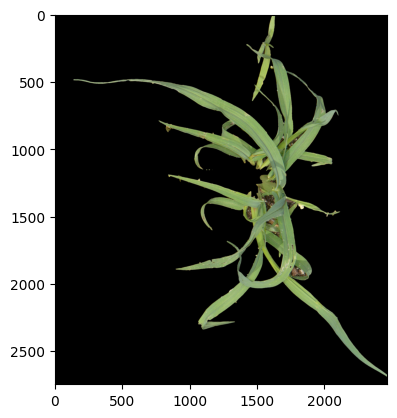

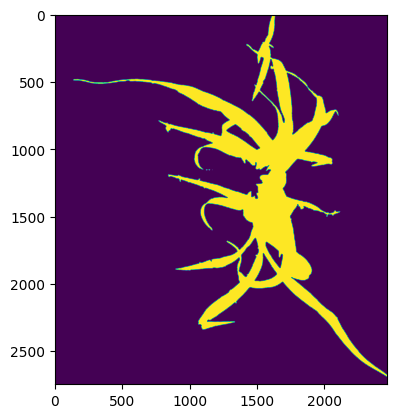

In [315]:
import numpy as np
import cv2

# given parameters
parent_pixel_width = 9560  # in pixels
parent_pixel_height = 6368  # in pixels
parent_fov_area = 1.6  #area  # in square meters


def leaf_area(parent_pixel_width, parent_pixel_height, parent_fov_area):

    sub_image_width = img.shape[1]  # in pixels
    sub_image_height = img.shape[0]  # in pixels

    # calculate ground area covered by a single pixel in the parent image
    parent_area_per_pixel = parent_fov_area / (
        parent_pixel_width * parent_pixel_height)  # in square meters

    # calculate ground area covered by a single pixel in the sub-image
    sub_image_area_per_pixel = parent_area_per_pixel  # since both images have the same scale

    # read the mask (assumed to be a binary image where leaf pixels are 1 and all others are 0)
    image_mask_path = image_path.replace(".png", "_mask.png")
    mask = cv2.imread(image_mask_path, cv2.IMREAD_GRAYSCALE)

    # count the number of pixels that correspond to the leaf
    leaf_pixel_count = np.sum(
        mask !=
        0)  # assumes that the leaf is represented by 255 (white) in the mask

    # calculate the leaf area
    leaf_area = leaf_pixel_count * sub_image_area_per_pixel
    return sub_image_area_per_pixel, mask, leaf_area


sub_image_area_per_pixel, mask, leaf_area = leaf_area(parent_pixel_width,
                                                      parent_pixel_height,
                                                      parent_fov_area)
print(sub_image_area_per_pixel)

print(f'The leaf covers an area of {leaf_area * 100} square meters')
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()